### Import necessary Module

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 345kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.88MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


Epoch 1, Loss: 0.0066
Epoch 2, Loss: 0.0341
Epoch 3, Loss: 0.0082


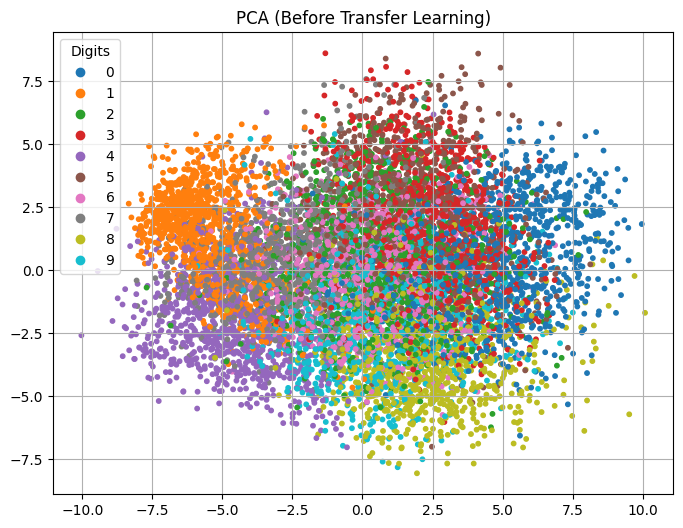

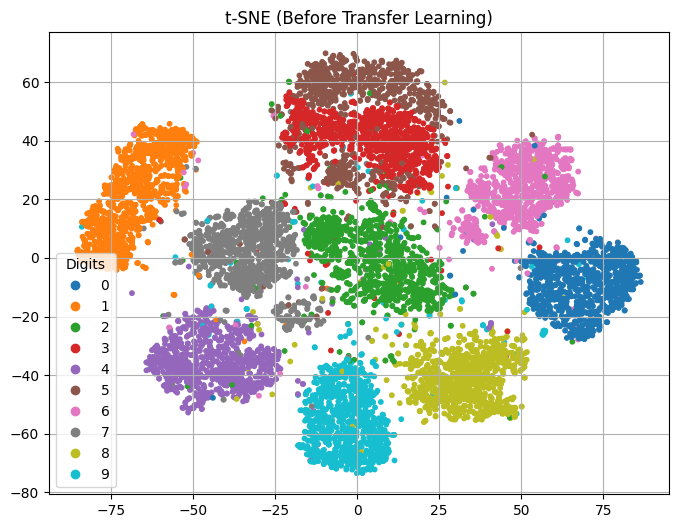

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


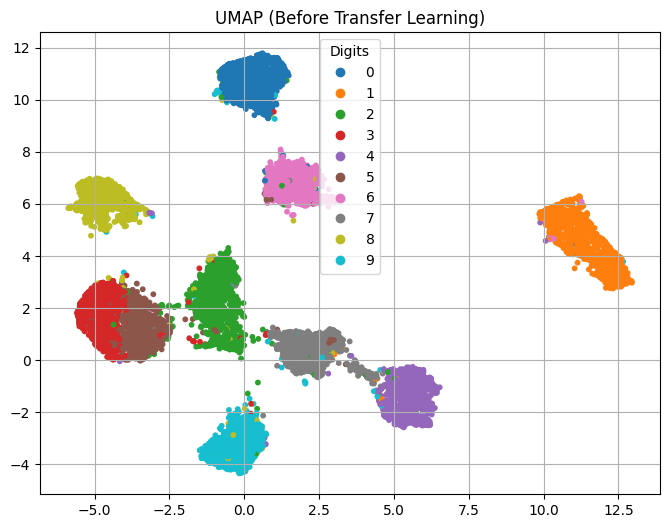

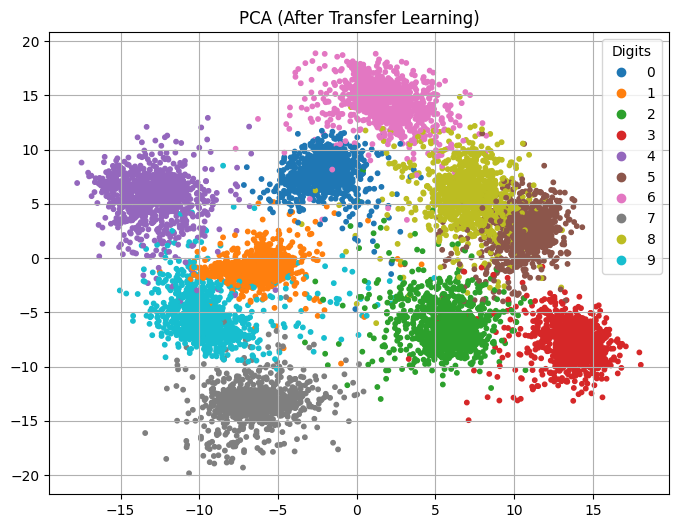

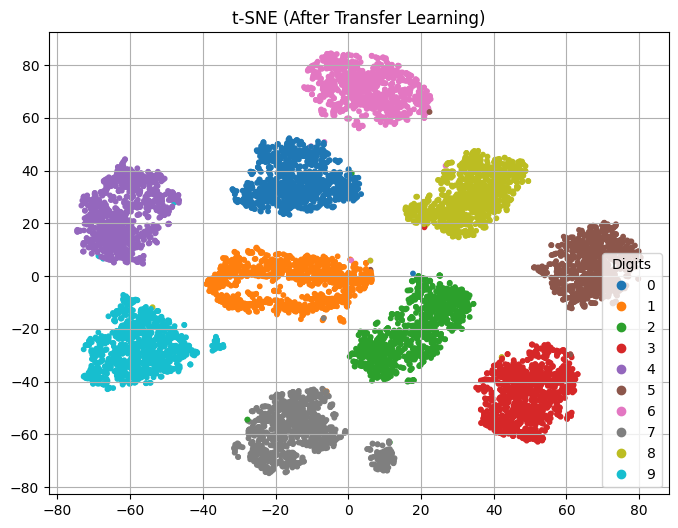

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


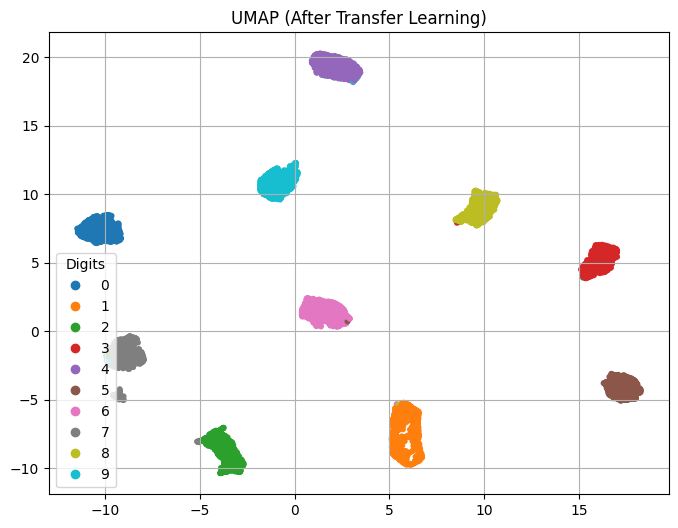

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST, convert to RGB
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

train_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_mnist, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_mnist, batch_size=128, shuffle=False)

# ========== PART 1: BEFORE TRANSFER LEARNING ==========
resnet_before = resnet18(pretrained=True)
resnet_before.fc = nn.Identity()
resnet_before.eval().to(device)

features_before, labels_before = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = resnet_before(imgs).cpu().numpy()
        features_before.append(feats)
        labels_before.append(labels.numpy())
X_before = np.concatenate(features_before)
y_before = np.concatenate(labels_before)

# ========== PART 2: TRANSFER LEARNING (Fine-tune) ==========
# Prepare model for fine-tuning
resnet_after = resnet18(pretrained=True)
resnet_after.fc = nn.Linear(512, 10)  # 10 output classes for MNIST
resnet_after = resnet_after.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_after.parameters(), lr=1e-4)

# Train only for a few epochs (demo)
resnet_after.train()
for epoch in range(3):
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_after(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Set to eval and replace classifier with Identity for feature extraction
resnet_after.fc = nn.Identity()
resnet_after.eval()

features_after, labels_after = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = resnet_after(imgs).cpu().numpy()
        features_after.append(feats)
        labels_after.append(labels.numpy())
X_after = np.concatenate(features_after)
y_after = np.concatenate(labels_after)

# ========== PART 3: DIMENSIONALITY REDUCTION AND PLOTTING ==========
def plot_2d(data, labels, title):
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Digits", loc='best')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Before Transfer Learning
plot_2d(PCA(n_components=2).fit_transform(X_before), y_before, "PCA (Before Transfer Learning)")
plot_2d(TSNE(n_components=2, random_state=42).fit_transform(X_before), y_before, "t-SNE (Before Transfer Learning)")
plot_2d(umap.UMAP(n_components=2, random_state=42).fit_transform(X_before), y_before, "UMAP (Before Transfer Learning)")

# After Transfer Learning
plot_2d(PCA(n_components=2).fit_transform(X_after), y_after, "PCA (After Transfer Learning)")
plot_2d(TSNE(n_components=2, random_state=42).fit_transform(X_after), y_after, "t-SNE (After Transfer Learning)")
plot_2d(umap.UMAP(n_components=2, random_state=42).fit_transform(X_after), y_after, "UMAP (After Transfer Learning)")
